In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
# from sklearn import metrics
# from sklearn.preprocessing import StandardScaler
# from scipy.stats import norm
# import statsmodels.api as sm
%matplotlib inline

### Get VTI history

In [2]:
vti = yf.Ticker("VTI")
vti_hist = vti.history(period="max")

#### Get top 10 holding in VTI


##### * Top 10 holdings were NOT found programatically. This info has yet to be found in the vti object *

In [3]:
microsoft = yf.Ticker('MSFT')
apple = yf.Ticker('AAPL')
amazon = yf.Ticker('AMZN')
facebook = yf.Ticker('FB')
alphabetA = yf.Ticker('GOOGL')
alphabetC = yf.Ticker('GOOG')
johnson = yf.Ticker('JNJ')
berkshire = yf.Ticker('BRK.B')
visa = yf.Ticker('V')
proctor = yf.Ticker('PG')

In [4]:
vti_holdings = [microsoft,apple,amazon,facebook,alphabetA,alphabetC,johnson,berkshire,visa,proctor]

#### Get DOW

In [6]:
dow = yf.Ticker('DJIA')

#### Visualy look for trends

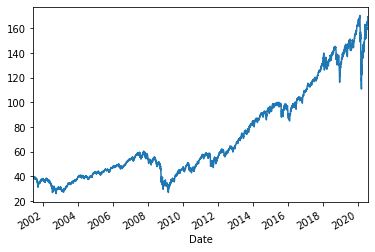

In [12]:
vti_hist.Close.plot()

#### test for stationarity

In [ ]:
adfuller(vti_hist)